In [1]:
import os
num_threads = "16"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [2]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
import gwot
from gwot import models, sim, ts, util
import gwot.bridgesampling as bs
import dcor
from tqdm import tqdm

sys.path.append("..")
import importlib
import models
import random
import model_fig1 as model_sim
# import mmd

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
PLT_CELL = 2.5

In [4]:
import glob

fnames_all = glob.glob("out_N_*.npy")
fnames_all_gwot = glob.glob("out_gwot_N_*.npy")

In [5]:
srand_all = np.array([int(f.split("_")[4]) for f in fnames_all])
srand_all_gwot = np.array([int(f.split("_")[5]) for f in fnames_all_gwot])

In [6]:
lamda_all = np.array([float(f.split("_")[6].split(".npy")[0]) for f in fnames_all])
lamda_all_gwot = np.array([float(f.split("_")[7].split(".npy")[0]) for f in fnames_all_gwot])

In [7]:
N_all = np.array([int(f.split("_")[2]) for f in fnames_all])
N_all_gwot = np.array([int(f.split("_")[3]) for f in fnames_all_gwot])

In [8]:
x_all = [np.load(f, allow_pickle = True).item(0)["x"] for f in fnames_all]
x_gwot_all = [np.load(f, allow_pickle = True).item(0)["samples_gwot"] for f in fnames_all_gwot]

In [9]:
# setup simulation object
sim = gwot.sim.Simulation(V = model_sim.Psi, dV = model_sim.dPsi, birth_death = False, 
                          N = None,
                          T = model_sim.T, 
                          d = model_sim.dim, 
                          D = model_sim.D, 
                          t_final = model_sim.t_final, 
                          ic_func = model_sim.ic_func, 
                          pool = None)

sim_gt = copy.deepcopy(sim)
sim_gt.N = np.array([1_000, ]*model_sim.T)
sim_gt.sample(steps_scale = int(model_sim.sim_steps/sim.T));

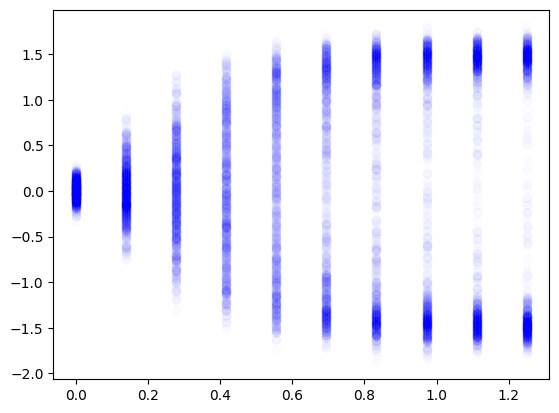

In [10]:
plt.scatter(np.linspace(0, model_sim.t_final, model_sim.T)[sim_gt.t_idx], sim_gt.x[:, 0], alpha = 0.01, color = "blue")

In [11]:
x_all[0].shape

torch.Size([10, 100, 10])

In [12]:
with torch.no_grad():
    d_reconstruct = np.array([[dcor.energy_distance(sim_gt.x[sim_gt.t_idx == i, :], x_all[j][i, :]) for i in range(x_all[j].shape[0])] for j in tqdm(range(len(x_all)), position = 0, leave = True)])
d_gwot = np.array([[dcor.energy_distance(sim_gt.x[sim_gt.t_idx == i, :], x_gwot_all[j][i, :]) for i in range(x_gwot_all[j].shape[0])] for j in tqdm(range(len(x_gwot_all)), position = 0, leave = True)])

100%|██████████| 18/18 [00:00<00:00, 26.40it/s]


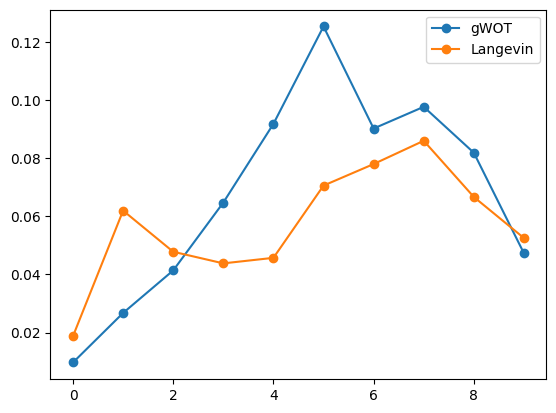

In [14]:
# plt.plot(d_gwot[(N_all_gwot == 1) & (lamda_all_gwot == 0.005), :].mean(0), 'o-', label = "gWOT")
# plt.plot(d_reconstruct[(N_all == 1) & (lamda_all == 0.05), :].mean(0), 'o-', label = "Langevin")
# Get the smallest N value available
min_N = min(N_all)
# Get a middle lambda value
mid_lamda = lamda_all[len(lamda_all)//2]

plt.plot(d_gwot[(N_all_gwot == min_N) & (lamda_all_gwot == 0.005), :].mean(0), 'o-', label = "gWOT")
plt.plot(d_reconstruct[(N_all == min_N) & (lamda_all == mid_lamda), :].mean(0), 'o-', label = "Langevin")
plt.legend()


Quantitative Comparison (Energy Distance metrics):

GWOT Method:
- Average Error: 0.2601
- Std Dev: 0.2331
- Range: [0.0967, 0.5116]

Langevin Method:
- Average Error: 0.2391
- Std Dev: 0.1606
- Range: [0.1216, 0.3521]

Relative Performance:
- GWOT vs Langevin ratio: 1.0878
  (ratio < 1 means GWOT performs better)



Text(0, 0.5, 'Energy Distance')

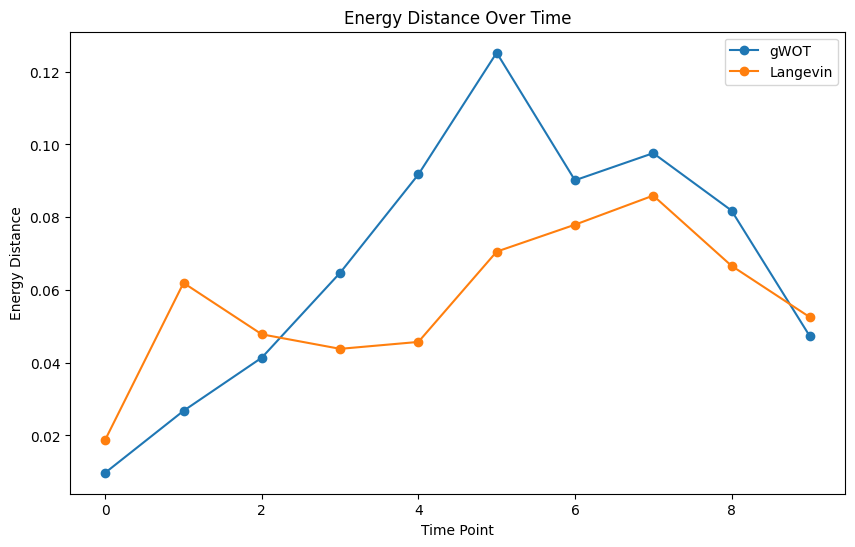

In [16]:
# Calculate average Energy Distance across time points for each method
avg_error_gwot = np.sqrt(d_gwot[(N_all_gwot == min_N) & (lamda_all_gwot == 0.005), :].mean())
avg_error_langevin = np.sqrt(d_reconstruct[(N_all == min_N) & (lamda_all == mid_lamda), :].mean())

# Calculate standard deviations
std_error_gwot = np.sqrt(d_gwot[(N_all_gwot == min_N) & (lamda_all_gwot == 0.005), :].std())
std_error_langevin = np.sqrt(d_reconstruct[(N_all == min_N) & (lamda_all == mid_lamda), :].std())

# Calculate min and max errors
min_error_gwot = np.sqrt(d_gwot[(N_all_gwot == min_N) & (lamda_all_gwot == 0.005), :].min())
max_error_gwot = np.sqrt(d_gwot[(N_all_gwot == min_N) & (lamda_all_gwot == 0.005), :].max())
min_error_langevin = np.sqrt(d_reconstruct[(N_all == min_N) & (lamda_all == mid_lamda), :].min())
max_error_langevin = np.sqrt(d_reconstruct[(N_all == min_N) & (lamda_all == mid_lamda), :].max())

print(f"""
Quantitative Comparison (Energy Distance metrics):

GWOT Method:
- Average Error: {avg_error_gwot:.4f}
- Std Dev: {std_error_gwot:.4f}
- Range: [{min_error_gwot:.4f}, {max_error_gwot:.4f}]

Langevin Method:
- Average Error: {avg_error_langevin:.4f}
- Std Dev: {std_error_langevin:.4f}
- Range: [{min_error_langevin:.4f}, {max_error_langevin:.4f}]

Relative Performance:
- GWOT vs Langevin ratio: {avg_error_gwot/avg_error_langevin:.4f}
  (ratio < 1 means GWOT performs better)
""")

# Original visualization
plt.figure(figsize=(10, 6))
plt.plot(d_gwot[(N_all_gwot == min_N) & (lamda_all_gwot == 0.005), :].mean(0), 'o-', label="gWOT")
plt.plot(d_reconstruct[(N_all == min_N) & (lamda_all == mid_lamda), :].mean(0), 'o-', label="Langevin")
plt.legend()
plt.title("Energy Distance Over Time")
plt.xlabel("Time Point")
plt.ylabel("Energy Distance")

In [15]:
fnames_all[0]

'out_N_64_srand_3_lamda_0.025.npy'

In [18]:
N_vals, _ = np.unique(N_all, return_index = True)
N_vals_gwot, _ = np.unique(N_all_gwot, return_index = True)
lamda_vals, _ = np.unique(lamda_all, return_index = True)
lamda_vals_gwot, _ = np.unique(lamda_all_gwot, return_index = True)
srand_vals, _ = np.unique(srand_all, return_index = True)
srand_vals_gwot, _ = np.unique(srand_all_gwot, return_index = True)

In [19]:
d_reconstruct_tensor = np.full((len(N_vals), len(lamda_vals), len(srand_vals), sim_gt.T), float("NaN"))
for (_N, _lamda, _srand) in zip(N_all, lamda_all, srand_all):
    d_reconstruct_tensor[N_vals == _N, lamda_vals == _lamda, srand_vals == _srand, :] = d_reconstruct[(N_all == _N) & (lamda_all == _lamda) & (srand_all == _srand), :].flatten()

d_gwot_tensor = np.full((len(N_vals_gwot), len(lamda_vals_gwot), len(srand_vals_gwot), sim_gt.T), float("NaN"))
for (_N, _lamda, _srand) in zip(N_all_gwot, lamda_all_gwot, srand_all_gwot):
    d_gwot_tensor[N_vals_gwot == _N, lamda_vals_gwot == _lamda, srand_vals_gwot == _srand, :] = d_gwot[(N_all_gwot == _N) & (lamda_all_gwot == _lamda) & (srand_all_gwot == _srand), :].flatten()

Text(0.5, 1.0, 'gWOT')

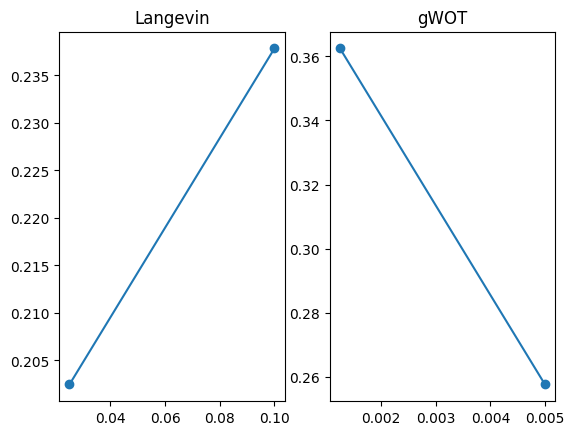

In [20]:
plt.subplot(1, 2, 1)
plt.plot(lamda_vals, np.sqrt(d_reconstruct_tensor[0].mean(-1)).mean(-1), 'o-')
plt.title("Langevin")
plt.subplot(1, 2, 2)
plt.plot(lamda_vals_gwot, np.sqrt(d_gwot_tensor[0].mean(-1)).mean(-1), 'o-')
plt.title("gWOT")

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_20860/4150027330.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")
/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_20860/4150027330.py:18: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")


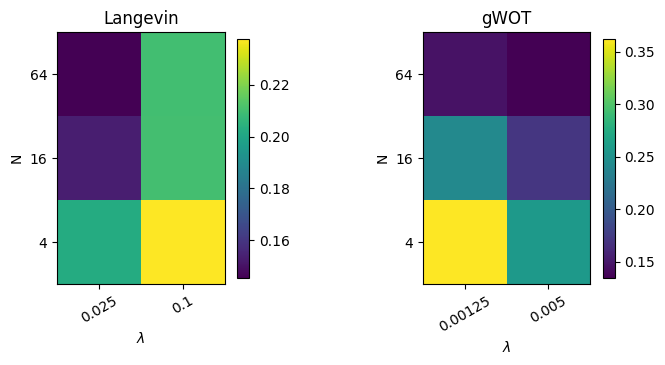

In [22]:
plt.figure(figsize = (3*PLT_CELL, 3/2*PLT_CELL))
plt.subplot(1, 2, 1)
# im = plt.imshow(np.nanmean(d_reconstruct_tensor, (2, 3)), origin = "lower")
im = plt.imshow(np.sqrt(d_reconstruct_tensor.mean(-1)).mean(-1), origin = "lower")
plt.xticks(range(len(lamda_vals)), lamda_vals, rotation = 30)
plt.yticks(range(len(N_vals)), N_vals)
plt.colorbar(im,fraction=0.038, pad=0.04)
plt.xlabel("$\lambda$")
plt.ylabel("N")
plt.title("Langevin")

plt.subplot(1, 2, 2)
# im = plt.imshow(np.nanmean(d_gwot_tensor, (2, 3)), origin = "lower")
im = plt.imshow(np.sqrt(d_gwot_tensor.mean(-1)).mean(-1), origin = "lower")
plt.xticks(range(len(lamda_vals_gwot)), lamda_vals_gwot, rotation = 30)
plt.yticks(range(len(N_vals_gwot)), N_vals_gwot)
plt.colorbar(im,fraction=0.038, pad=0.04)
plt.xlabel("$\lambda$")
plt.ylabel("N")
plt.title("gWOT")

plt.tight_layout()

In [23]:
np.sqrt(d_reconstruct_tensor.mean(-1)).mean(-1)

array([[0.20246341, 0.23783592],
       [0.15309609, 0.21033574],
       [0.1455031 , 0.2100439 ]])

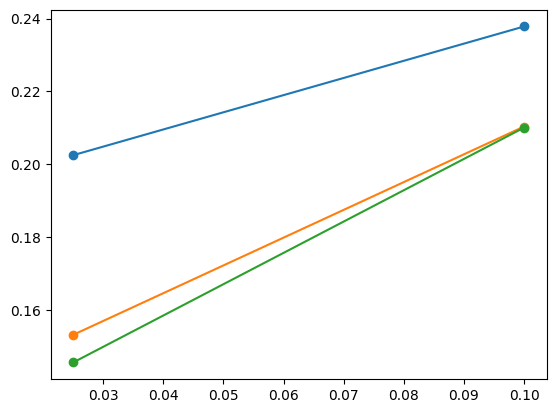

In [24]:
plt.plot(lamda_vals, np.sqrt(d_reconstruct_tensor.mean(-1)).mean(-1).T, 'o-');

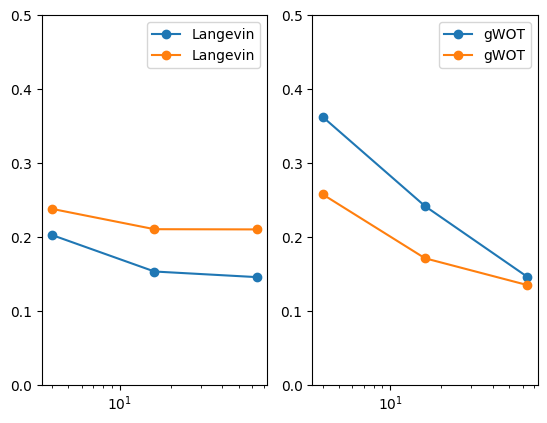

In [25]:
plt.subplot(1, 2, 1)
plt.plot(N_vals, np.sqrt(d_reconstruct_tensor.mean(-1)).mean(-1), 'o-', label = "Langevin");
plt.ylim(0, 0.5)
plt.legend()
plt.xscale("log")
plt.subplot(1, 2, 2)
plt.plot(N_vals, np.sqrt(d_gwot_tensor.mean(-1)).mean(-1), 'o-', label = "gWOT");
plt.ylim(0, 0.5)
plt.legend()
plt.xscale("log")

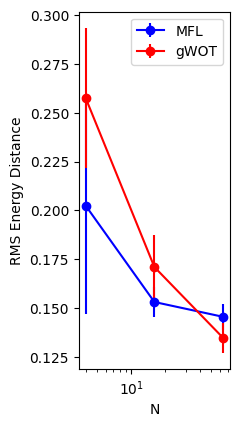

In [26]:
plt.figure(figsize = (PLT_CELL, 1.75*PLT_CELL))

sds = np.std(np.sqrt(d_reconstruct_tensor.mean(-1)), axis = 2)
means = np.sqrt(d_reconstruct_tensor.mean(-1)).mean(-1)
min_idx = np.nanargmin(means, axis = 1)
sds_minmean = np.array([x[y] for (x, y) in zip(sds, min_idx)])
plt.errorbar(N_vals, np.nanmin(means, 1), sds_minmean, label = "MFL", color = "blue", marker = "o")

sds = np.std(np.sqrt(d_gwot_tensor.mean(-1)), axis = 2)
means = np.sqrt(d_gwot_tensor.mean(-1)).mean(-1)
min_idx = np.nanargmin(means, axis = 1)
sds_minmean = np.array([x[y] for (x, y) in zip(sds, min_idx)])
plt.errorbar(N_vals, np.nanmin(means, 1), sds_minmean, label = "gWOT", color = "red", marker = "o")

plt.ylabel("RMS Energy Distance")
plt.xlabel("N")

plt.xscale("log")
plt.legend()

plt.tight_layout()
plt.savefig("../fig1_distances.pdf")